In [51]:
import numpy as np
import cv2 as cv
import load_things as io
import pycocotools.mask as rletools
from matplotlib import pyplot as plt

Loading sequence 0007
1
1000
{'size': [375, 1242], 'counts': b'Slk4660m:`0L4XEYOZ:X1J2M7J1O1N3N1O1O001O1ON2O11M3N1O200N2N2O1O1N200M3O1O1O1O1O1O100O1N200O100O1O1O100O1000O10O1000000000000O1000000000000000O100000000000000000000O100000000000000O01000000000000000O10000000000001O001O2N1O01O001O00001N2O1N3K3CmFTNW9i1=N3M3M3N3L2O1O1000O11bNmET1_:M2MSSl7'}
375


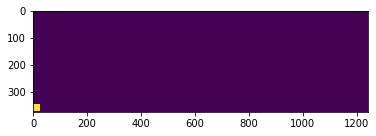

In [121]:
# Read sequences 0000 and 0001
seqmap = ['0007'] 
path = '/home/grupo08/datasets/KITTI_MOTS/instances_txt/'

objects = io.load_sequences(path, seqmap)
print(objects['0007'][0][0].class_id)
print(objects['0007'][0][0].track_id)
print(objects['0007'][0][0].mask)

print(objects['0007'][0][0].mask['size'][0])

x = rletools.decode(objects['0007'][564][0].mask)
x = np.array(x)
plt.imshow(x) 

Loading sequence 0000


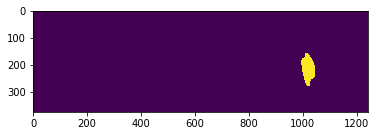

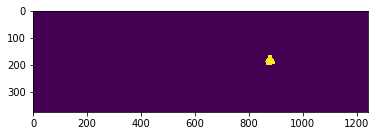

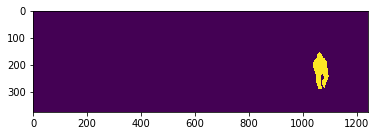

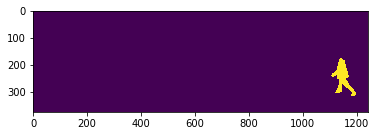

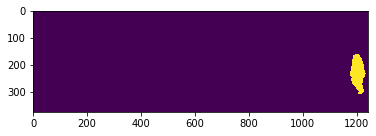

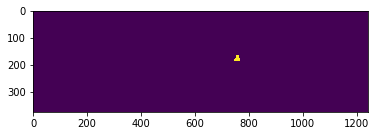

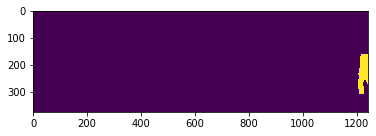

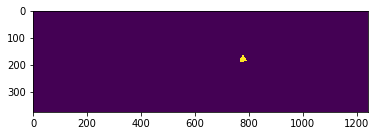

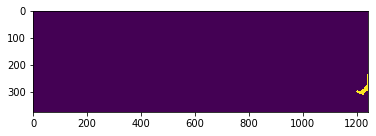

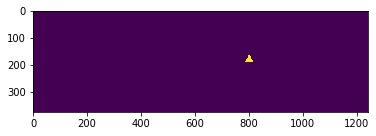

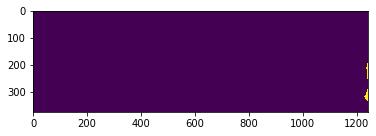

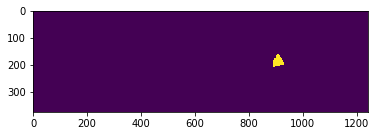

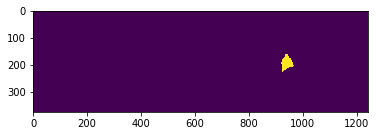

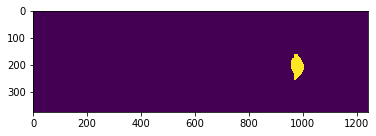

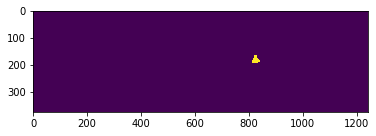

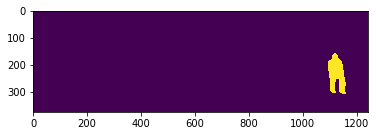

In [81]:
# imports
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import glob


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# utils to read
import load_things as io
import pycocotools.mask as rletools

import os
import numpy as np
import json
from detectron2.structures import BoxMode

"""
classes = { 'Pedestrian': 2, 
            'Car': 1 }
"""

def get_KITTI_MOTS_dicts(img_dir, seqmap, is_train=True):

    # Obtain all the data from the seqmap
    path = '/home/grupo08/datasets/KITTI_MOTS/instances_txt/'
    objects = io.load_sequences(path, seqmap)

    # Iterate through all the sequences
    dataset_dicts = []
    for seq in seqmap:
        print(seq)
        image_paths = sorted(glob.glob(img_dir + seq + '/*.png'))
        # For each sequence, use only 70% of the data
        random.seed(42)
        ids = list(objects[seq].keys())
        #ids = list(range(0,len(image_paths)))
        random.shuffle(ids)

        if(is_train):
            ids = ids[0:round(0.7*len(ids))]
        else:
            ids = ids[(round(0.7*len(ids))+1):-1]

        # Iterate through the frames in ids (train or val)
        for i in ids:
            record = {}
            #height, width = cv2.imread(image_paths[i]).shape[:2]
            record["file_name"] = image_paths[i]
            record["image_id"] = seq + str(i)
            record["height"] = objects[seq][i][0].mask['size'][0]
            record["width"] = objects[seq][i][0].mask['size'][1]

            # Iterate through all the instances in the i-th frame for sequence seq
            objs = []
            for instance in objects[seq][i]:
                # class_id=10 means ignore instance
                if(instance.class_id==10):
                    continue
                # Decode the mask
                x = rletools.decode(instance.mask)
                x = np.array(x)
                # Find the edges of the mask
                pos = np.where(x>0)
                tl = [np.min(pos[0]), np.min(pos[1])]
                br = [np.max(pos[0]), np.max(pos[1])]

                obj = {
                    "bbox": [np.min(pos[0]), np.min(pos[1]), np.max(pos[0]), np.max(pos[1])],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": instance.class_id
                }
                objs.append(obj)

            record["annotations"] = objs
            dataset_dicts.append(record)
    
    print('Loaded ' + str(np.shape(dataset_dicts)[0]) + ' images!')
    return(dataset_dicts)


from detectron2.data import DatasetCatalog, MetadataCatalog

# 0-->None, 1-->Car, 2--->Pedestrian
class_list =   ['None','Car','Pedestrian']
# Sequences to load:
seqmap = ['0000','0001','0002','0003','0004','0005','0006','0007','0008','0009',
          '0010','0011','0012','0013','0014','0015','0016','0017','0018','0019','0020']

d = "train"
DatasetCatalog.register("KITTI_MOTS_" + d, 
    lambda d=d: get_KITTI_MOTS_dicts("/home/mcv/datasets/KITTI-MOTS/training/image_02/", seqmap, is_train=True))
MetadataCatalog.get("KITTI_MOTS_" + d).set(thing_classes=class_list)

d = "val"
DatasetCatalog.register("KITTI_MOTS_" + d, 
    lambda d=d: get_KITTI_MOTS_dicts("/home/mcv/datasets/KITTI-MOTS/training/image_02/", seqmap, is_train=False))
MetadataCatalog.get("KITTI_MOTS_" + d).set(thing_classes=class_list)

KITTI_metadata = MetadataCatalog.get("KITTI_MOTS_train")
print(KITTI_metadata)

dataset_dicts = get_KITTI_MOTS_dicts("/home/mcv/datasets/KITTI-MOTS/training/image_02/", seqmap, is_train=True)
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=KITTI_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2.imwrite("img.jpg", vis.get_image()[:, :, ::-1])